In [1]:
import os

import cmcrameri.cm as cmc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns



In [2]:
combined = pd.read_csv('/home/earthquakes1/homes/Rebecca/phd/stf/data/combined.csv')

In [3]:
def get_stf(scardec_name, wanted_type = 'fctopt'):
    db = combined[combined['scardec_name']==scardec_name]

    time = []
    momentrate = []

    event = os.listdir(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}')
    starts = [n for n, l in enumerate(event) if l.startswith(wanted_type)]
    with open(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}/{event[starts[0]]}') as f:
        lines = f.read().splitlines()

    lines = lines[2:]
    for line in lines:
        split = line.split(' ')
        split = [s for s in split if s not in ['', ' ', '\n']]
        time.append(float(split[0]))
        momentrate.append(float(split[1]))

    momentrate = np.array(momentrate)
    return momentrate, time, db

In [4]:
# looks for time value of root
def f3(end_time, total_moment, time_opt, momentrate_opt, start, points_before_zero, proportion = 0.1):
    dx = time_opt[1]-time_opt[0]
    end_window = (end_time/dx)+points_before_zero
    end = int(np.floor(end_window))
    if start == end:
        end += 1
    short = scipy.integrate.simpson(momentrate_opt[start:end], dx = dx)
    return short-(total_moment*proportion)

In [5]:
def plot_scatter_figures(proportion, root_times, moments, durations):
    root_times = np.array(root_times)
    moments = np.array(moments)
    durations = np.array(durations)

    plt.scatter(root_times, durations, c = np.log10(moments), cmap = cmc.batlow, alpha = 0.5)
    plt.ylabel('Duration (s)')
    plt.xlabel(f'time to release {proportion*100}% of moment (s)')
    plt.colorbar(label = 'log10(moment)')
    plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/time_for_{proportion*100}_percent_moment_against_duration.png')
    plt.close()

    plt.scatter(root_times, np.log10(moments), c = durations, cmap = cmc.batlow, alpha = 0.5)
    plt.ylabel('log10(moment)')
    plt.xlabel(f'time to release {proportion*100}% of moment (s)')
    plt.colorbar(label = 'Duration (s)')
    plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/time_for_{proportion*100}_percent_moment_against_moment.png')
    plt.close()

    plt.scatter(root_times/durations, np.log10(moments), c = durations, cmap = cmc.batlow, alpha = 0.5)
    plt.ylabel('log10(moment)')
    plt.xlabel(f'proportion of duration to release {proportion*100}% of moment')
    plt.colorbar()
    plt.xlim(0, 1)
    plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/fraction_of_duration_for_{proportion*100}_percent_moment_against_moment.png')
    plt.close()

In [6]:
def plot_hist_figures(proportion, root_times, durations):
    root_times = np.array(root_times)
    durations = np.array(durations)

    plt.hist(root_times/durations, bins = 100)

    plt.ylabel('Frequency')
    plt.xlabel(f'Proportion of duration to release {proportion*100}% of moment')
    plt.xlim(0, 1)
    plt.show()
    #plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/histogram_fraction_of_duration_for_{proportion*100}_percent_moment.png')
    #plt.close()

In [7]:
proportions_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

all_durations = []
all_root_times = []
all_moments = []
all_relative_root_times = [[]]

for proportion in proportions_list:
    print(proportion)
    durations = []
    root_times = []
    relative_root_times = []

    diff = []
    moments = []

    for scardec_name in os.listdir('/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec'):
        #print(scardec_name)
        momentrate_opt, time_opt, db = get_stf(scardec_name, wanted_type='fctmoy')

        not_zero = np.where(momentrate_opt > 0)[0]

        dx = time_opt[1]-time_opt[0]

        start = min(not_zero)
        end = max(not_zero)
        points_before_zero = abs(min(time_opt)/dx)

        duration = time_opt[end] - time_opt[start]
        durations.append(duration)

        start_time = time_opt[start]
        end_time = time_opt[end]

        total_moment = scipy.integrate.simpson(momentrate_opt[start:end], dx = time_opt[1]-time_opt[0])
        moments.append(total_moment)
        root, r = scipy.optimize.bisect(f3,
                                        start_time+dx,
                                        end_time,
                                        rtol = 1e-6,
                                        full_output = True,
                                        args = (total_moment,
                                                time_opt,
                                                momentrate_opt,
                                                start,
                                                points_before_zero,
                                                proportion,))
        root_idx = np.floor(root/dx)
        root_time = root_idx*dx
        root_times.append(root_time)
        relative_root_times.append(root_time-start_time)

        if root_time-start_time > duration:
            print('root time greater than duration, proportion:', proportion)
            print(scardec_name)

    root_times = np.array(root_times)
    durations = np.array(durations)
    moments = np.log10(np.array(moments))
    relative_root_times = np.array(relative_root_times)

    rel_root_times = relative_root_times/durations

    all_relative_root_times.append(rel_root_times)


0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


In [31]:
proportions_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

#print(proportion)
durations = []
g_root_times = []
g_relative_root_times = []


for proportion in proportions_list:

    diff = []
    moments = []

    #for scardec_name in os.listdir('/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec'):
        #print(scardec_name)

    # Produce a Gaussian distribution
    def gaussian(x, mu, sigma):
        return (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma)**2)

    # Generate x values
    x = np.linspace(-4, 4, 100)

    # Parameters for the Gaussian
    mu = 0
    sigma = 1

    # Generate y values
    y = gaussian(x, mu, sigma)

    # Use the generated Gaussian values
    momentrate_opt, time_opt = y, x

    not_zero = np.where(momentrate_opt > 0)[0]

    dx = time_opt[1]-time_opt[0]

    start = min(not_zero)
    end = max(not_zero)
    points_before_zero = abs(min(time_opt)/dx)

    duration = time_opt[end] - time_opt[start]
    durations.append(duration)

    start_time = time_opt[start]
    end_time = time_opt[end]

    total_moment = scipy.integrate.simpson(momentrate_opt[start:end], dx = time_opt[1]-time_opt[0])
    moments.append(total_moment)
    g_root, r = scipy.optimize.bisect(f3,
                                    start_time+dx,
                                    end_time,
                                    rtol = 1e-6,
                                    full_output = True,
                                    args = (total_moment,
                                            time_opt,
                                            momentrate_opt,
                                            start,
                                            points_before_zero,
                                            proportion,))
    g_root_idx = np.floor(g_root/dx)
    g_root_time = g_root_idx*dx
    g_root_times.append(g_root_time)
    g_relative_root_times.append(g_root_time-start_time)



In [32]:
g_relative_root_times = np.array(g_relative_root_times)

In [33]:
g_relative_root_times/durations

array([0.34848485, 0.40909091, 0.44949495, 0.47979798, 0.51010101,
       0.54040404, 0.57070707, 0.61111111, 0.67171717])

In [11]:
all_relative_root_times.append([])

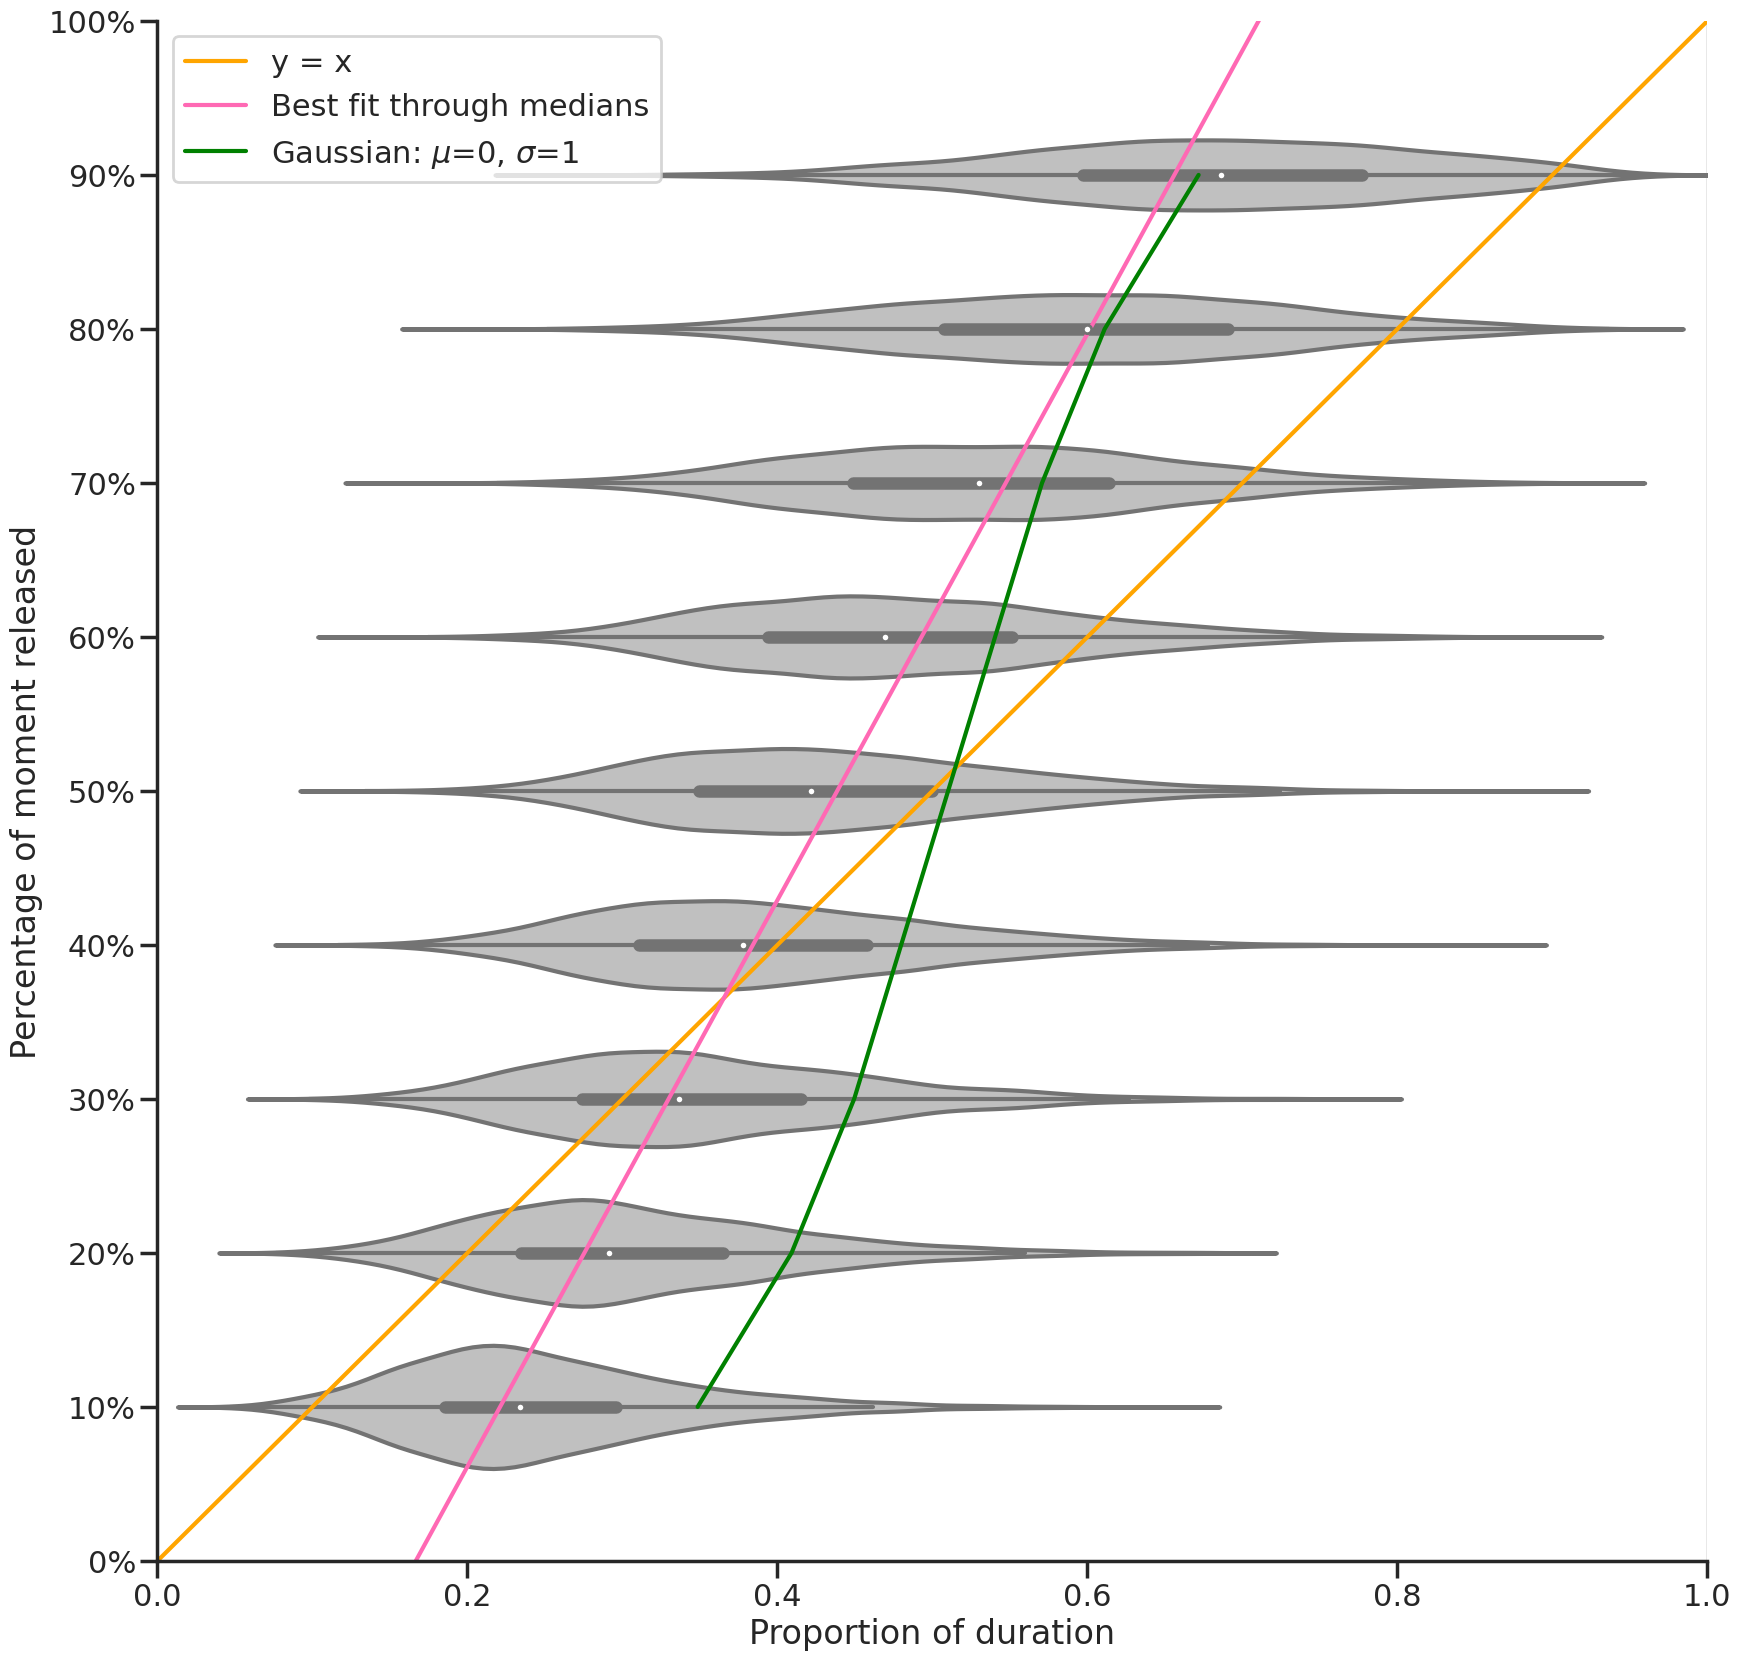

In [34]:
sns.set_theme(style="ticks", context="poster",rc={'figure.figsize':(20,20), "font.size":36})
ax = sns.violinplot(data = all_relative_root_times,
               orient = 'h',
               color = 'silver')
ax.set_yticks(np.arange(len(np.arange(0, 1.1, 0.1))), [f'{p*100:.0f}%' for p in np.arange(0, 1.1, 0.1)])

ax.set_ylabel('Percentage of moment released')
ax.set_xlabel('Proportion of duration')

ax.invert_yaxis()

ax.plot(np.arange(0, 1.1, 0.1),
        np.arange(0, 11, 1),
        c = 'orange',
        label = 'y = x',)

# Calculate the line of best fit
m, b = np.polyfit(np.mean(all_relative_root_times[1:-1], axis=1), np.arange(1, 10, 1), 1)
# Plot the line of best fit
# ax.plot(np.mean(all_relative_root_times[1:-1], axis=1),
#         m * np.mean(all_relative_root_times[1:-1], axis=1) + b,
#         c='red',
#         label = 'Mean LoBF',
#         linestyle = '--')

# Calculate the line of best fit
m, b = np.polyfit(np.median(all_relative_root_times[1:-1], axis=1), np.arange(1, 10, 1), 1)
# Plot the line of best fit
ax.plot(np.arange(0, 1, 0.1),
        m * np.arange(0, 1, 0.1) + b,
        c='hotpink',
        label = 'Best fit through medians',
        linestyle = '-')

ax.plot(g_relative_root_times/durations, np.arange(1, 10, 1), label = r'Gaussian: $\mu$=0, $\sigma$=1', c = 'green')

plt.ylim(-0, 10)
plt.xlim(0, 1)

ax.axvspan(1, 1.5, alpha = 0.2, color = 'grey')
plt.legend()
sns.despine()
plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/poster/violinplot_fraction_of_duration_for_percent_moment_with_gasussian.png', dpi = 300)

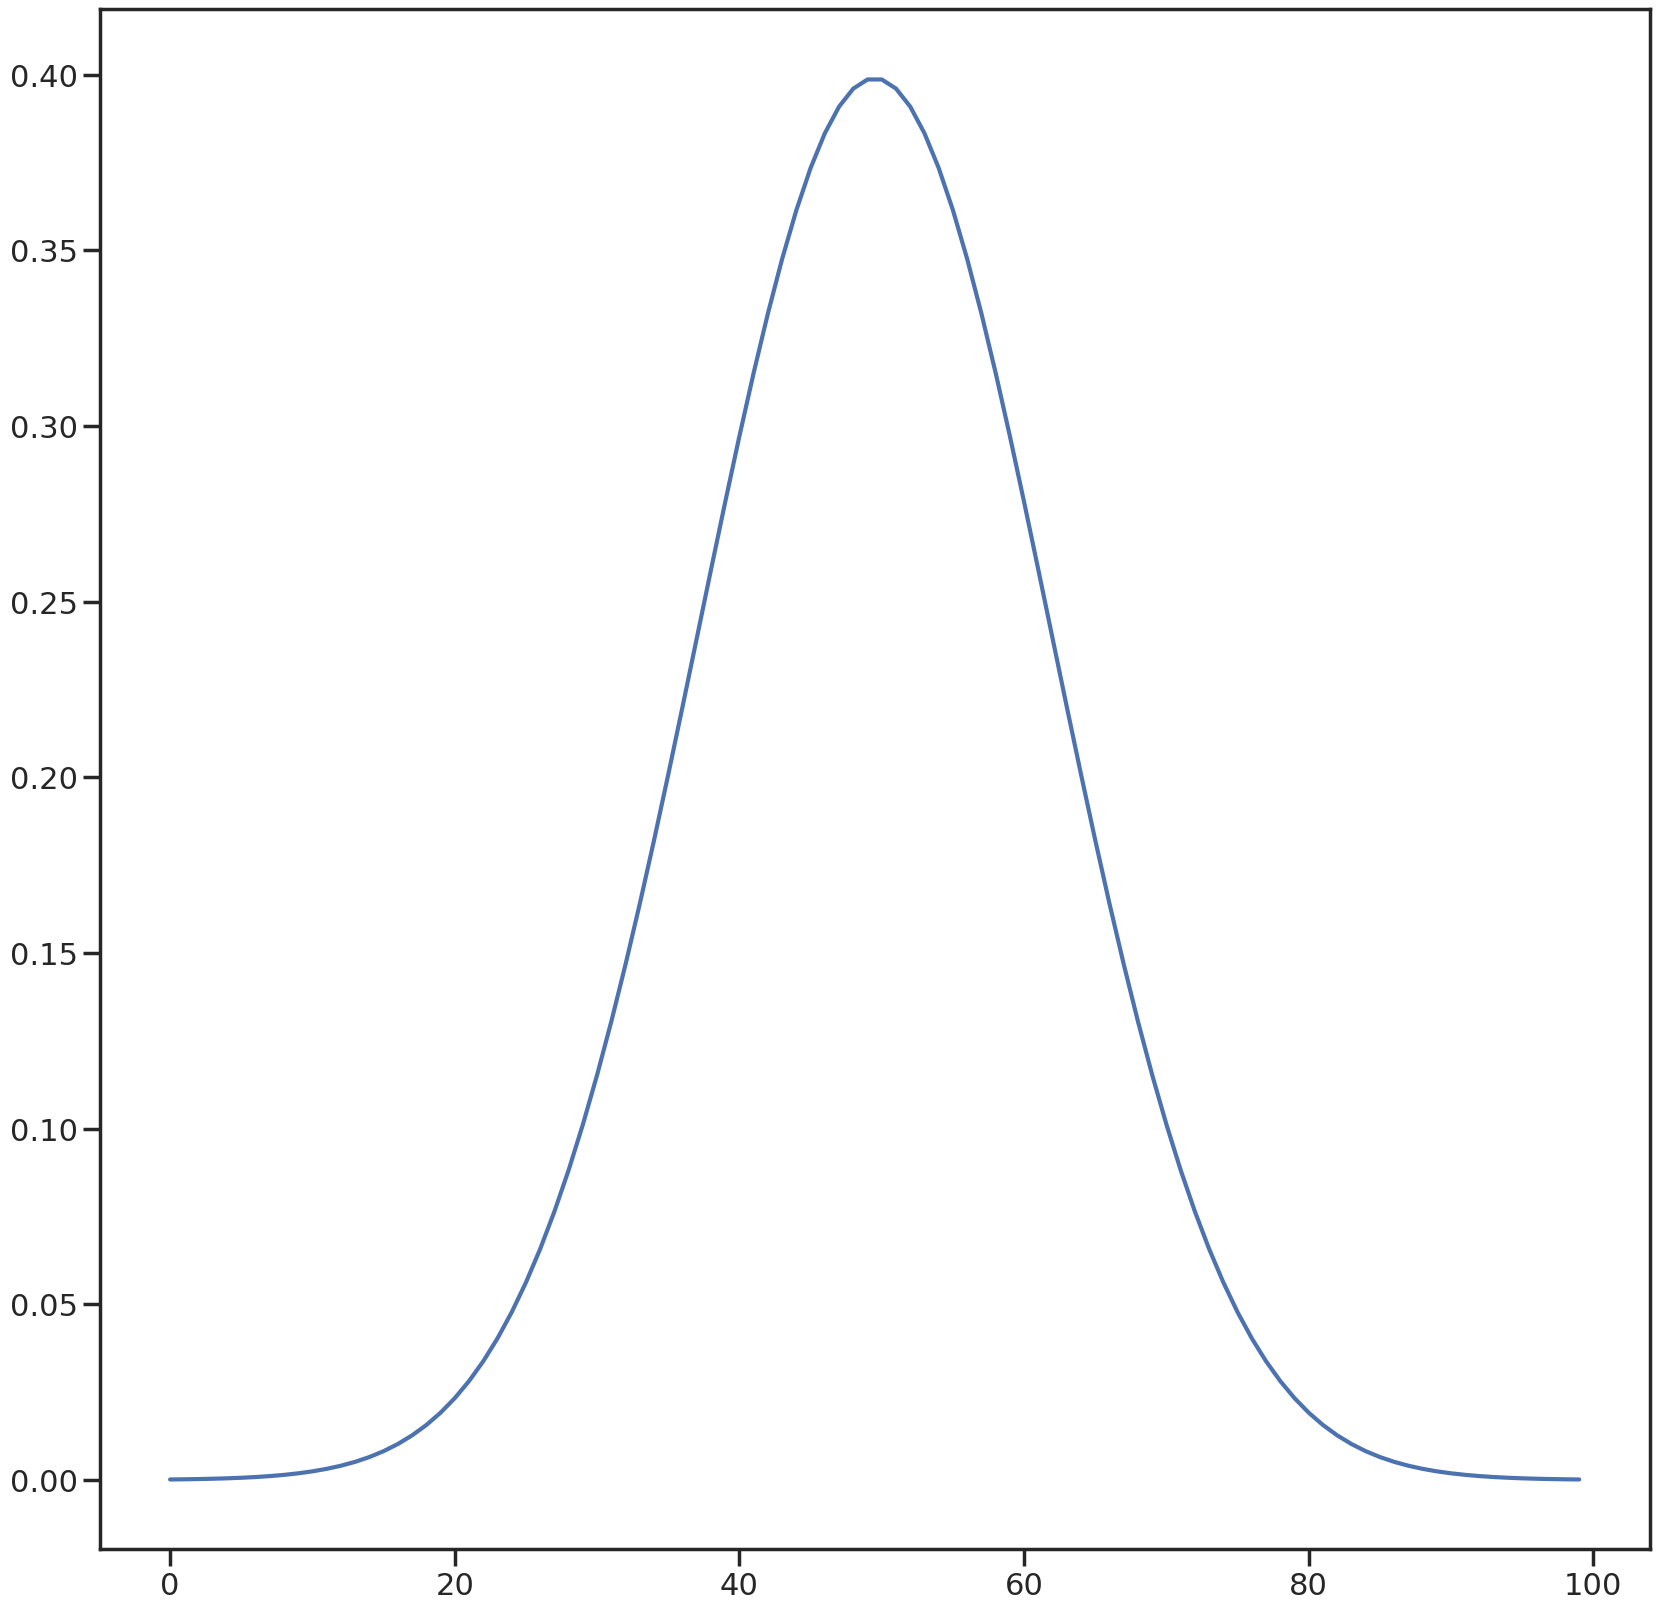

In [35]:
plt.plot(momentrate_opt, )

In [14]:
g_relative_root_times/durations

array([0.25757576, 0.34848485, 0.40909091, 0.45959596, 0.51010101,
       0.56060606, 0.61111111, 0.67171717, 0.76262626])

In [15]:
m * np.mean(all_relative_root_times[1:-1], axis=1) + b

array([1.47529755, 2.53107788, 3.34286965, 4.09125687, 4.86592548,
       5.72346138, 6.75104245, 7.96968706, 9.51606979])

In [16]:
all_relative_root_times

[[],
 array([0.36950147, 0.28389831, 0.09638554, ..., 0.22881356, 0.13247863,
        0.42253521]),
 array([0.44281525, 0.36864407, 0.13253012, ..., 0.27118644, 0.16666667,
        0.47887324]),
 array([0.52199413, 0.43220339, 0.15662651, ..., 0.30508474, 0.20512821,
        0.52112676]),
 array([0.6686217 , 0.47881356, 0.18072289, ..., 0.33898305, 0.32051282,
        0.56338028]),
 array([0.71847507, 0.52542373, 0.20481928, ..., 0.37288135, 0.3974359 ,
        0.6056338 ]),
 array([0.74486804, 0.56355932, 0.23493976, ..., 0.41525424, 0.43589744,
        0.61971831]),
 array([0.78005865, 0.59745763, 0.26506024, ..., 0.44067796, 0.47863248,
        0.66197183]),
 array([0.80645161, 0.63559322, 0.30120482, ..., 0.49152542, 0.52136752,
        0.70422535]),
 array([0.83577713, 0.68644068, 0.34939759, ..., 0.55932203, 0.82051282,
        0.74647887]),
 []]

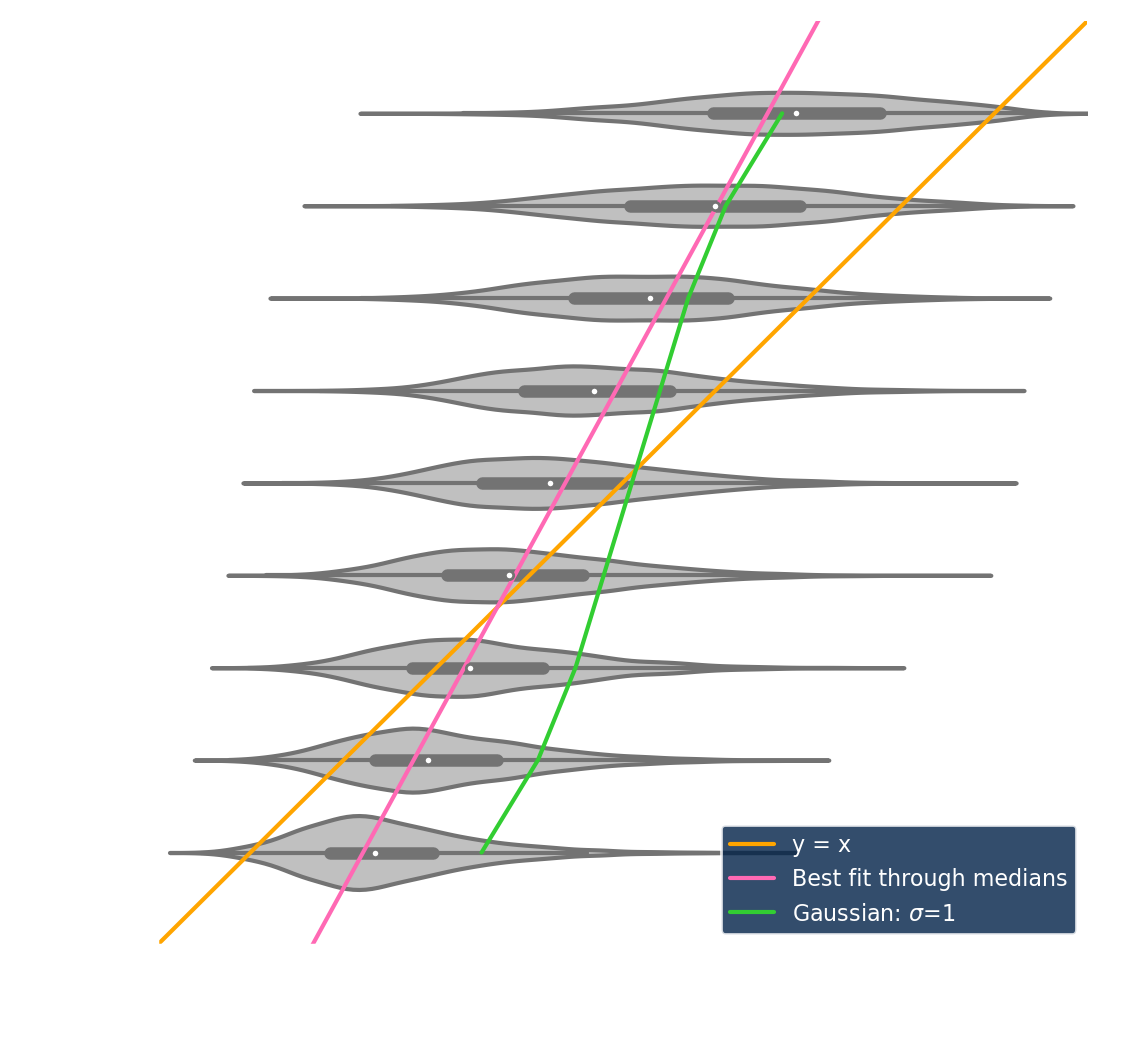

In [41]:
#sns.set_theme(style="ticks", context="poster",rc={'figure.figsize':(20,20), "font.size":36})

sns.set_theme(style='ticks',
              context='poster',
              rc={'figure.figsize':(12,12),
                  'font.size':36})

params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}
plt.rcParams.update(params)
plt.rc('legend',fontsize=20)

ax = sns.violinplot(data = all_relative_root_times,
               orient = 'h',
               color = 'silver')
ax.set_yticks(np.arange(len(np.arange(0, 1.1, 0.1))), [f'{p*100:.0f}%' for p in np.arange(0, 1.1, 0.1)])

ax.set_ylabel('Percentage of moment released')
ax.set_xlabel('Proportion of duration')

ax.invert_yaxis()

ax.plot(np.arange(0, 1.1, 0.1),
        np.arange(0, 11, 1),
        c = 'orange',
        label = 'y = x',)

# Calculate the line of best fit
m, b = np.polyfit(np.mean(all_relative_root_times[1:-1], axis=1), np.arange(1, 10, 1), 1)
# Plot the line of best fit
# ax.plot(np.mean(all_relative_root_times[1:-1], axis=1),
#         m * np.mean(all_relative_root_times[1:-1], axis=1) + b,
#         c='red',
#         label = 'Mean LoBF',
#         linestyle = '--')

# Calculate the line of best fit
m, b = np.polyfit(np.median(all_relative_root_times[1:-1], axis=1), np.arange(1, 10, 1), 1)
# Plot the line of best fit
ax.plot(np.arange(0, 1, 0.1),
        m * np.arange(0, 1, 0.1) + b,
        c='hotpink',
        label = 'Best fit through medians',
        linestyle = '-')

ax.plot(g_relative_root_times/durations, np.arange(1, 10, 1), label = r'Gaussian: $\sigma$=1', c = 'limegreen')

plt.ylim(-0, 10)
plt.xlim(0, 1)

#ax.axvspan(1, 1.5, alpha = 0.2, color = 'grey')
plt.legend(ncol = 1, facecolor = '#002147', edgecolor = 'white', labelcolor = 'white', fontsize = 16)
sns.despine()
plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/poster/violinplot_fraction_of_duration_for_percent_moment_with_gasussian_transparent.png', dpi = 300, transparent = True)